In [1]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import time
from scipy import sparse

import sys  
from importlib import reload  
import helper
reload(helper)
import helper as h

import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder = '/dss/dsshome1/lxc07/gobi009/data/' + 'GSE114297/'

In [4]:
#Load data
#adata = pickle.load(open(shared_folder + 'data_normalised.pkl', 'rb'))
#adata = h.open_h5ad(shared_folder + 'data_normalised.h5ad', unique_id2=UID2)
adata = sc.read_h5ad(shared_folder + 'data_normalised.h5ad')

## Load gene IDs

In [5]:
# Use EID info from cellrange data
# Assumes that all samples have same features, thus performs this for single sample

# Read CellRanger feature info
features_f = pd.read_table(shared_folder + 'UPR_features.tsv', header=None)
features_f.columns = ['EID', 'gene_symbol_adata', 'feature_type'][:features_f.shape[1]]
features_f.index = features_f['EID']

# map gene names from Cellranger to gene names used in adata
af = ann.AnnData(var=features_f)
af.var_names = features_f['gene_symbol_adata']
af.var_names_make_unique()
features_f['gene_symbol_adata'] = af.var_names

# load features from adata
features_used = adata.var_names
# Keep only features in adata
features_f.index = features_f['gene_symbol_adata']
adata.var['EID'] = features_f.loc[features_used, 'EID']

## Visualisation

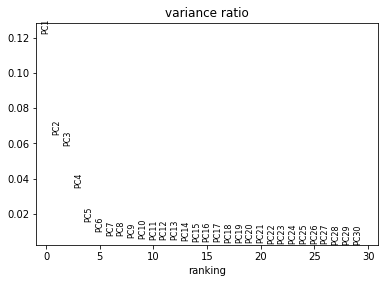

In [6]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [7]:
# Select number of PCs to use
N_PCS = 6

Compare different embeddings based on previously defined annotation. 

In [8]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

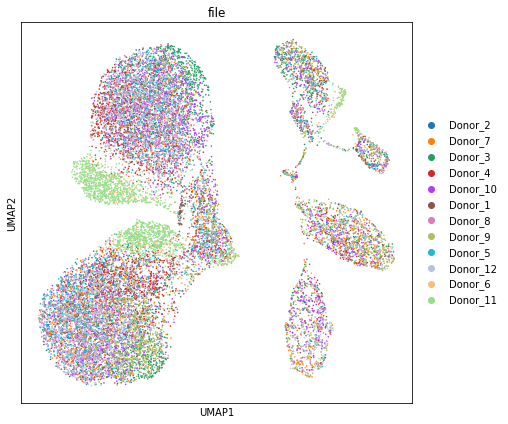

In [9]:
rcParams['figure.figsize'] = (7, 7)
sc.pl.umap(adata, size=10, color=['file'])

#### On scaled data

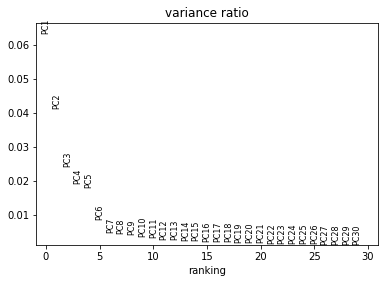

In [10]:
# Scale data and perform PCA
adata_scl = adata.copy()
sc.pp.scale(adata_scl, max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
rcParams['figure.figsize'] = (6, 4)
sc.pl.pca_variance_ratio(adata_scl)

In [11]:
#C: Can stay the same as above
N_PCS

6

In [12]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = 7) 

In [13]:
# Umap on scaled data
sc.tl.umap(adata_scl)

In [14]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl'] = adata_scl.obsm['X_umap']

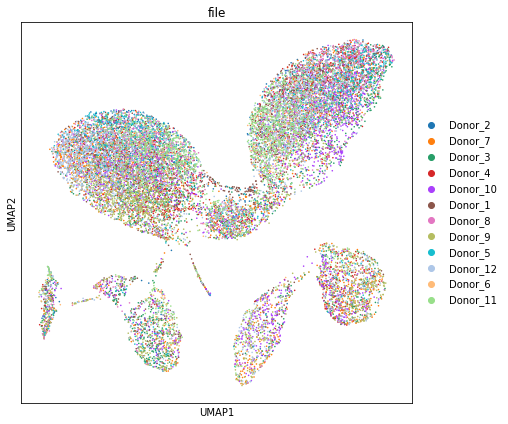

In [15]:
rcParams['figure.figsize'] = (7,7)
sc.pl.umap(adata_scl, size=10, color=['file'])

## Cell cycle
Performed separately for individual batches.

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [16]:
cyclone_anno = pickle.load(open(shared_folder + 'cyclone_anno.pkl', 'rb'))

In [17]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1     18839
S        321
G2M      120
Name: phase_cyclone, dtype: int64

In [18]:
# Add cyclone annotation to adata
cyclone_anno = cyclone_anno.reindex(adata.obs.index)
adata.obs = pd.concat([adata.obs,cyclone_anno], axis=1)

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase_cyclone' as categorical


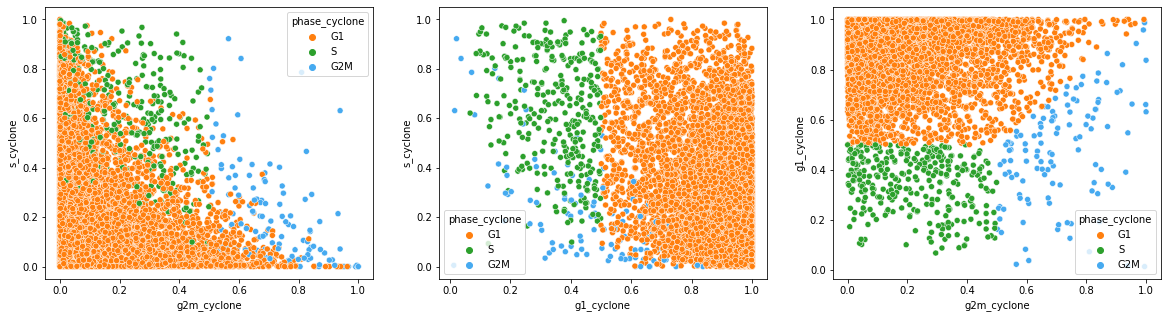

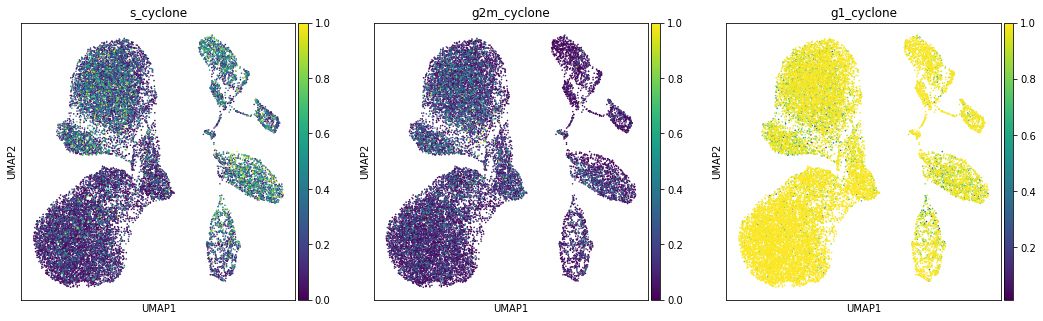

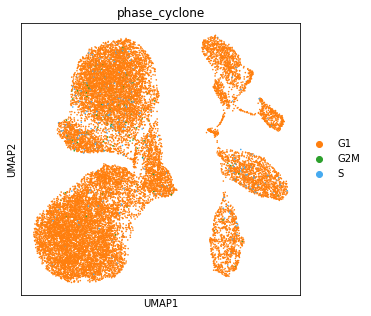

In [19]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize'] = (20,5)
fig,axs = plt.subplots(1, 3)
palette = sb.color_palette(['#ff7f0e', '#2ca02c', '#46aaf0'])
sb.scatterplot(x='g2m_cyclone', y='s_cyclone', hue='phase_cyclone', data=cyclone_anno, ax=axs[0], palette=palette)
sb.scatterplot(x='g1_cyclone', y='s_cyclone', hue='phase_cyclone', data=cyclone_anno, ax=axs[1], palette=palette)
sb.scatterplot(x='g2m_cyclone', y='g1_cyclone', hue='phase_cyclone', data=cyclone_anno, ax=axs[2], palette=palette)
rcParams['figure.figsize'] = (5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone', 'g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors'] = ['#ff7f0e', '#2ca02c', '#46aaf0']
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

MKI67 expression for comparison with cell cycle anno:

In [20]:
print('MKI67 in adata:', sum(adata.var.index == 'MKI67'))
print('MKI67 in adata_raw (only gene expression filtering):', sum(adata.raw.var.index == 'MKI67'))
print('MKI67 in cellranger data:', features_f.query('gene_symbol_adata == "MKI67"').shape[0])

MKI67 in adata: 1
MKI67 in adata_raw (only gene expression filtering): 1
MKI67 in cellranger data: 1


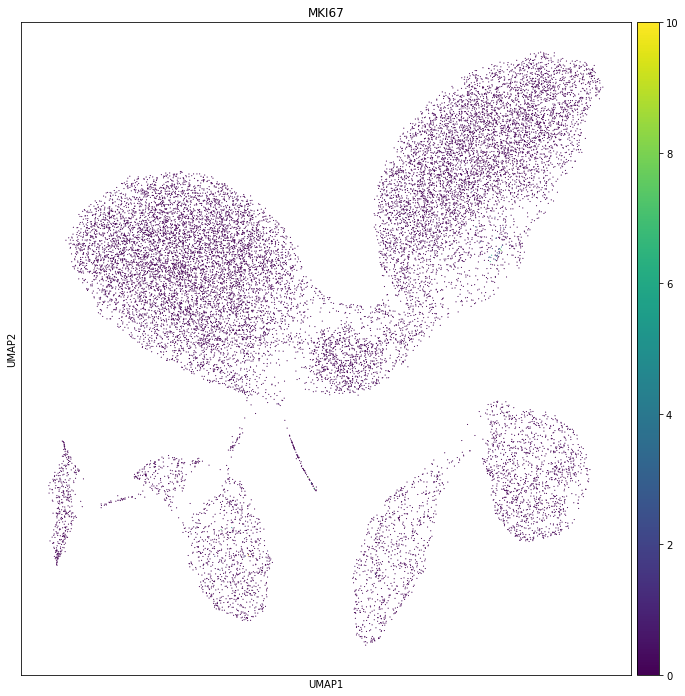

Amount of cells MKI67 is expressed in: 50
Total amount of cells: 19280


In [21]:
rcParams['figure.figsize'] = (12, 12)
sc.pl.umap(adata_scl, color='MKI67' ,size=5, use_raw=True)
print('Amount of cells MKI67 is expressed in:', adata.var.loc['MKI67']['n_cells'])
print('Total amount of cells:', adata_scl.X.shape[0])

## Save intermediate results before cell type annotation

# Cell type annotation

In [ ]:
# adata = h.open_h5ad(shared_folder+"data_annotated.h5ad",unique_id2=UID2)
# adata = sc.read(shared_folder+"data_annotated.h5ad")
# adata = pickle.load(open(shared_folder + 'data_annotated.pkl', 'rb'))
# adata = pickle.load(open(shared_folder + 'data_normalised.pkl', 'rb'))
adata

## Endo high annotation

In [ ]:
# Normalise raw data for cell type scoring
adata_rawnorm = adata.raw.to_adata().copy()
adata_rawnorm.X /= adata.obs['size_factors'].values[:, None] # This reshapes the size-factors array
sc.pp.log1p(adata_rawnorm)
adata_rawnorm.X = np.asarray(adata_rawnorm.X)
adata_rawnorm.obs = adata.obs.copy()

#### Ins

In [ ]:
# Compute Ins score
sc.tl.score_genes(adata_rawnorm, gene_list=['INS'], score_name='ins_score',  use_raw=False)

In [ ]:
#sc.pl.violin(adata_rawnorm, keys=['ins_score'], groupby='file', stripplot=False, jitter=True)
ins_scores = adata_rawnorm.obs[['ins_score','file']]
ins_scores['ins_score_norm'] = pp.minmax_scale(ins_scores.ins_score)
rcParams['figure.figsize'] = (12, 15)
fig,axs = plt.subplots(3, 1)
sb.violinplot(x='file', y='ins_score', data=ins_scores,inner=None,ax=axs[0])
axs[0].title.set_text('Ins scores')
axs[0].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled Ins scores')
axs[1].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores[ins_scores.ins_score_norm>0.3],inner=None,ax=axs[2])
axs[2].title.set_text('Scaled Ins scores without very low Ins cells')
axs[2].grid()

In [ ]:
# Find ins high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds = {'Donor_1': 0.5, 'Donor_2': 0.5, 'Donor_3': 0.5, 'Donor_4': 0.5, 'Donor_5': 0.5, 'Donor_6': 0.5, 'Donor_7': 0.5, 'Donor_8': 0.5, 'Donor_9': 0.5, 'Donor_10': 0.5, 'Donor_11': 0.5, 'Donor_12': 0.5}
adata_rawnorm.obs['ins_high'] = ins_scores.apply(lambda x: x.ins_score_norm > file_thresholds[x.file], axis=1)
print('Proportion of ins high across samples:')
adata_rawnorm.obs[['file', 'ins_high']].groupby('file').ins_high.value_counts(normalize=True, sort=False)

In [ ]:
# Add info about ins high to main adata and save it
adata.obs['ins_score'] = adata_rawnorm.obs['ins_score']
adata.obs['ins_high'] = adata_rawnorm.obs['ins_high']

#### Gcg

In [ ]:
genes = ['GCG']
score_name = 'gcg'

In [ ]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name + '_score',  use_raw=False)

In [ ]:
print(score_name)
scores = adata_rawnorm.obs[[score_name + '_score', 'file']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (12, 15)
fig, axs = plt.subplots(3, 1)
sb.violinplot(x='file', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores')
axs[0].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name +' scores')
axs[1].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > 0.15], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + ' scores without very low ' + score_name + ' cells')
axs[2].grid()

In [ ]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds = {'Donor_1': 0.5, 'Donor_2': 0.5, 'Donor_3': 0.5, 'Donor_4': 0.5, 'Donor_5': 0.5, 'Donor_6': 0.5, 'Donor_7': 0.5, 'Donor_8': 0.5, 'Donor_9': 0.5, 'Donor_10': 0.5, 'Donor_11': 0.5, 'Donor_12': 0.5}
adata_rawnorm.obs[score_name + '_high'] = scores.apply(lambda x: x[score_name + '_score_norm'] > file_thresholds[x.file], axis=1)
print('Proportion of ' + score_name + ' high across samples:')
adata_rawnorm.obs[['file', score_name + '_high']].groupby('file')[score_name + '_high'].value_counts(normalize=True, sort=False)

In [ ]:
# Add info about score high to main adata and save it
adata.obs[score_name + '_score'] = adata_rawnorm.obs[score_name + '_score']
adata.obs[score_name + '_high'] = adata_rawnorm.obs[score_name + '_high']

#### SSt

In [ ]:
genes = ['SST']
score_name = 'sst'

In [ ]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name + '_score', use_raw=False)

In [ ]:
scores = adata_rawnorm.obs[[score_name + '_score','file']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (12, 15)
fig,axs = plt.subplots(3, 1)
sb.violinplot(x='file', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores')
axs[0].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name + ' scores')
axs[1].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > 0.15], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + ' scores without very low ' + score_name + ' cells')
axs[2].grid()

In [ ]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds = {'Donor_1': 0.5, 'Donor_2': 0.5, 'Donor_3': 0.5, 'Donor_4': 0.5, 'Donor_5': 0.5, 'Donor_6': 0.5, 'Donor_7': 0.5, 'Donor_8': 0.5, 'Donor_9': 0.5, 'Donor_10': 0.5, 'Donor_11': 0.5, 'Donor_12': 0.5}
adata_rawnorm.obs[score_name + '_high'] = scores.apply(lambda x: x[score_name + '_score_norm'] > file_thresholds[x.file], axis=1)
print('Proportion of ' + score_name + ' high across samples:')
adata_rawnorm.obs[['file',score_name + '_high']].groupby('file')[score_name + '_high'].value_counts(normalize=True, sort=False)

In [ ]:
# Add info about score high to main adata and save it
adata.obs[score_name + '_score'] = adata_rawnorm.obs[score_name + '_score']
adata.obs[score_name + '_high'] = adata_rawnorm.obs[score_name + '_high']

#### Ppy

In [ ]:
genes = ['PPY']
score_name = 'ppy'

In [ ]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name + '_score', use_raw=False)

In [ ]:
scores = adata_rawnorm.obs[[score_name + '_score','file']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (12, 15)
fig,axs = plt.subplots(3, 1)
sb.violinplot(x='file', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores')
axs[0].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name + ' scores')
axs[1].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > 0.2], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + ' scores without very low ' + score_name + ' cells')
axs[2].grid()

In [ ]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds = {'Donor_1': 0.5, 'Donor_2': 0.5, 'Donor_3': 0.5, 'Donor_4': 0.5, 'Donor_5': 0.5, 'Donor_6': 0.5, 'Donor_7': 0.5, 'Donor_8': 0.5, 'Donor_9': 0.5, 'Donor_10': 0.5, 'Donor_11': 0.5, 'Donor_12': 0.5}

adata_rawnorm.obs[score_name + '_high'] = scores.apply(lambda x: x[score_name + '_score_norm'] > file_thresholds[x.file], axis=1)
print('Proportion of ' + score_name + ' high across samples:')
adata_rawnorm.obs[['file', score_name + '_high']].groupby('file')[score_name + '_high'].value_counts(normalize=True, sort=False)

In [ ]:
# Add info about score high to main adata and save it
adata.obs[score_name + '_score'] = adata_rawnorm.obs[score_name + '_score']
adata.obs[score_name + '_high'] = adata_rawnorm.obs[score_name + '_high']

#### Ghrl

In [ ]:
genes=['GHRL']
score_name='ghrl'

In [ ]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name + '_score',  use_raw=False)

In [ ]:
scores = adata_rawnorm.obs[[score_name + '_score', 'file']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (12, 15)
fig,axs = plt.subplots(3, 1)
sb.violinplot(x='file', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores')
axs[0].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name + ' scores')
axs[1].grid()
sb.violinplot(x='file', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > 0.15], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + ' scores without very low ' + score_name + ' cells')
axs[2].grid()

In [ ]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds = {'Donor_1': 0.5, 'Donor_2': 0.5, 'Donor_3': 0.5, 'Donor_4': 0.5, 'Donor_5': 0.5, 'Donor_6': 0.5, 'Donor_7': 0.5, 'Donor_8': 0.5, 'Donor_9': 0.5, 'Donor_10': 0.5, 'Donor_11': 0.5, 'Donor_12': 0.5}
adata_rawnorm.obs[score_name + '_high'] = scores.apply(lambda x: x[score_name + '_score_norm'] > file_thresholds[x.file], axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file', score_name + '_high']].groupby('file')[score_name + '_high'].value_counts(normalize=True, sort=False)

In [ ]:
# Add info about score high to main adata and save it
adata.obs[score_name + '_score'] = adata_rawnorm.obs[score_name + '_score']
adata.obs[score_name + '_high'] = adata_rawnorm.obs[score_name + '_high']

#### Save

In [ ]:
# h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)
# adata.write(shared_folder + 'data_annotated.h5ad')
pickle.dump(adata, open(shared_folder + 'data_annotated.pkl', 'wb'))

## All cell types

## Clustering

#### Leiden clustering on log transformed data.

In [ ]:
adata

In [ ]:
sc.tl.leiden(adata, resolution=0.4)

In [ ]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['leiden'], size=10, use_raw=False)

In [ ]:
#del adata_scl.uns['sex_colors']
rcParams['figure.figsize'] = (6, 6)
random_indices = np.random.permutation(list(range(adata_scl.shape[0])))
sc.pl.umap(adata_scl[random_indices, :], color=['file', 'phase_cyclone'], size=10, use_raw=False, wspace=0.3, sort_order=False)
# sc.pl.umap(adata_scl[random_indices, :], color=['file'], size=10, use_raw=False, wspace=0.3, sort_order=False)

In [ ]:
# Clustering resolution
res = 1

In [ ]:
# Cluster scaled data
sc.tl.leiden(adata_scl, resolution=res, key_added='leiden_scaled_r' + str(res), directed=True, use_weights=True)

In [ ]:
# Compare UMAPs and clusters on scaled data
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata_scl, color=['leiden_scaled_r' + str(res)], size=10, use_raw=False)

In [ ]:
# Compare UMAPs and clusters on scaled data
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata_scl, color=['leiden_scaled_r' + str(res)], size=10, use_raw=False, legend_loc='on data')

#C: Umaps and clusterings on z-scaled data and non-z-scaled data perform similarly. z-scaled data will be used for consistency with other analysed studies.

## Cell type annotation

In [ ]:
# Normalise raw data for plotting and cell type scoring
adata_raw = adata_scl.raw.to_adata().copy()
sc.pp.normalize_total(adata_raw, target_sum=1e4, exclude_highly_expressed=True, inplace=False)
sc.pp.log1p(adata_raw)
adata_rawnormalised = adata_scl.copy()
adata_rawnormalised.raw = adata_raw
del adata_raw

In [ ]:
# Markers data
marker_data = pd.read_excel('/dss/dsshome1/lxc07/gobi009/hafner/code/marker_genes_collection.xlsx',
             sheet_name='Collection table')

In [ ]:
# Load orthologues so that mice markers can be also checked out
orthologues = pd.read_table('/dss/dsshome1/lxc07/gobi009/hafner/code/orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv')

In [ ]:
# Plot doublet score
sc.pl.umap(adata_rawnormalised, color='doublet_score', size=10, use_raw=True)

C: It seems that some doublets may be present

In [ ]:
# Plot markers for each cell type
# Fillna as else groupby item iteration does not work well
marker_groups = marker_data.fillna('NA').query('tissue == "pancreas"').groupby(['cell_type', 'subtype'])
for cell_type,data in marker_groups:
    print(cell_type)
    # For mouse subset to markers that worked
    genes_mouse = set(data.query('worked == worked & organism == "Mus musculus"').gene_name) # worked==worked removes nan values
    genes_mouse_orthologues = set(orthologues[orthologues['Gene name'].isin(genes_mouse)]['Human gene name'])
    # For mouse also use just upper case representation
    # But exclude those that are not in adata from the start as they amy not be valid human genes
    genes_mouse_upper = set([gene.upper() for gene in genes_mouse if  gene.upper() in adata.var_names])
    # Human gene markers
    genes_human = set(data.query('organism == "Homo sapiens"').gene_name) 
    # Combination of all markers
    genes = genes_human | genes_mouse_upper | genes_mouse_orthologues
    # Retain genes present in raw var_names
    missing = [gene for gene in genes if gene not in adata.raw.var_names]
    genes = [gene for gene in genes if gene in adata.raw.var_names]
    if len(genes) > 0:
        print('Missing genes:', missing)
        rcParams['figure.figsize'] = (4, 4)
        #sc.pl.umap(adata_rawnormalised, color=['pre_cell_type'],size=10, use_raw=True)
        sc.pl.umap(adata_rawnormalised, color=genes, size=10, use_raw=True)
    else:
        print('No availiable genes (out of:', missing, ')\n')

In [ ]:
# Selected markers that seem to be able to distinguish between cell types
# Use only hormone genes for endocrine cells
markers_selection = {
    'schwann': ['SOX10', 'PLP1'],
    'endothelial': ['PECAM1', 'PLVAP'],
    'immune': ['PTPRC'],
    'alpha': ['GCG'], # Also others
    'delta': ['SST'],
    'gamma': ['PPY'],
    # Also many other acinar marker genes
    'acinar': ['CELA2A', 'KLK1', 'CPB1', 'PNLIP', 'CPA1', 'CELA3B', 'CPA2', 'PNLIPRP1', 'CEL'],
    'ductal': ['S100A14'],
    'epsilon': ['GHRL'],
    'stellate_activated': ['RGS5'],
    'stellate_quiescent': ['PDGFRA'],
    'beta': ['INS'], #Also others
}

### Marker expression scores
Score each cell for marker expression of each cell type. Cells can thus be annotated qith 0 to N cell types. The presence of annotations is then checked for each cluster.

In [ ]:
#Score cells for each cell type

# Save score column names 
scores = []
for cell_type, genes in markers_selection.items():
    score_name = cell_type + '_score'
    scores.append(cell_type + '_score')
    sc.tl.score_genes(adata_rawnormalised, gene_list=genes, score_name=score_name, use_raw=True)

In [ ]:
# Which clusters (column name) to analyse for cell scores
res = 1
clusters_col = 'leiden_scaled_r' + str(res)

In [ ]:
# Add cluster information to the used adata
adata_rawnormalised.obs[clusters_col] = adata_scl.obs[clusters_col].copy()

In [ ]:
# Plot scores distribution across clusters
rcParams['figure.figsize']=(10,3)
for score in scores:
    fig, ax = plt.subplots()
    sc.pl.violin(adata_rawnormalised, keys=score, groupby=clusters_col, use_raw=True, stripplot=False, ax=ax, show=False)
    ax.grid()

In [ ]:
# Scores normalised to interval [0,1] for each cell type - so that they can be more easily compared
scores_df = adata_rawnormalised.obs[scores]
# Do not use normalisation so that it is more comparable to above
# scores_df_norm = pd.DataFrame(pp.minmax_scale(scores_df_norm), columns=scores_df_norm.columns, index=adata_rawnormalised.obs.index)

In [ ]:
thresholds_map = {
    'schwann_score': 0.2,
    'endothelial_score': 0.1,
    'immune_score': 0.5,
    'alpha_score': 2.5,
    'delta_score': 5,
    'gamma_score': 5.5,
    'acinar_score': 1,
    'ductal_score': 0,
    'epsilon_score': 2.7,
    'stellate_activated_score': 0.2,
    'stellate_quiescent_score': 0.1,
    'beta_score': 5
}

In [ ]:
# Distn of scores across all cells to account for different N of cells across clusters
for score in scores_df.columns:
    thr = thresholds_map[score]
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist(scores_df[score], bins=50)
    ax[1].hist(scores_df[score], bins=50)
    fig.suptitle(score)
    ax[1].set_yscale('log')
    ax[1].grid()
    ax[0].axvline(thr, c='k')
    ax[1].axvline(thr, c='k')

In [ ]:
# Thresholds for cell type assignemnt based on normalised scores
thresholds = scores_df.columns.map(thresholds_map)

In [ ]:
# Assign cell types based on scores to each cell
assignment_df = scores_df >= thresholds
assignment_df.columns = [col.replace('_score', '') for col in scores_df.columns]

In [ ]:
# Count of cells per cell type
assignment_df[[col.replace('_score', '') for col in scores_df.columns]].sum()

In [ ]:
# How many cell types were annotated to each cell
rcParams['figure.figsize'] = (5, 5)
a = plt.hist(assignment_df.sum(axis=1))

In [ ]:
# For each cell make a (standard) string of annotated cell types: 
# e.g. each annotated cell type in the same order, separated by '_' when multiple cell types were annotated
type_unions = []
for idx, row in assignment_df.iterrows():
    type_union = ''
    for col in sorted(row.index):
        if row[col]:
            type_union = type_union + col + '_'
    if type_union == '':
        type_union = 'NA'
    type_unions.append(type_union.rstrip('_'))

In [ ]:
# Add cell types strings of cells to scores/assignment DF
assignment_df['type_union'] = type_unions
assignment_df[clusters_col] = adata_rawnormalised.obs[clusters_col].values

### Annotate clusters

In [ ]:
# Make DF of marker gene expressions (normalised, log transformed), scaled for each gene to [0,1]
used_markers = list(dict.fromkeys([marker for marker_list in markers_selection.values() for marker in marker_list]))
gene_idx = adata_rawnormalised.raw.var_names.isin(used_markers)
genes = adata_rawnormalised.raw.var_names[gene_idx]
scaled_expression = pd.DataFrame(pp.minmax_scale(adata_rawnormalised.raw.X.toarray()[:, gene_idx]), columns=genes,index=adata_rawnormalised.obs.index)[[marker for marker in used_markers if marker in genes]]

In [ ]:
def add_category(df, idxs, col, category):
    """
    Add single value to multiple rows of DF column (useful when column might be categorical). 
    If column is categorical the value is beforehand added in the list of present categories 
    (required for categorical columns). 
    :param df: DF to which to add values
    :param idxs: Index names of rows where the value should be assigned to the column.
    :param col: Column to which to add the value.
    :param category: The value to add to rows,column.
    """
    # If column is already present, is categorical and value is not in categories add the value to categories first.
    if col in df.columns and df[col].dtype.name == 'category' and category not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories([category])
    df.loc[idxs, col] = category

In [ ]:
def subcluster(adata_cluster, res, original_cluster, assignment_df_temp, clusters_name_prefix='leiden_scaled_r'):
    """
    Cluster adata and add reult into cell type assignment DF. Plot the clustering on UMAP.
    Add name of the original cluster to which the adata belongs to new cluster names.
    Cluster column name: clusters_name_prefix+str(res) 
    :param adata_cluster: Adata (with already computed neighbours and UMAP) to cluster with leiden clustering. 
    :param res: Leiden resolution
    :param original_cluster: Original cluster name, new clusters are named 'original cluster'+'_'+'new cluster'
    :param assignment_df_temp: assignment_df to which to add clusters - should have same row order as adata
    :param clusters_name_prefix: Prefix for cluster column name.
    """
    clusters_col_name = clusters_name_prefix + str(res)
    sc.tl.leiden(adata_cluster, resolution=res, key_added=clusters_col_name, directed=True, use_weights=True)
    adata_cluster.obs[clusters_col_name] = [original_cluster + '_' + subcluster for subcluster in adata_cluster.obs[clusters_col_name]]
    sc.pl.umap(adata_cluster, color=clusters_col_name)
    time.sleep(1.0)
    
    assignment_df_temp['leiden_scaled_r' + str(res)] = adata_cluster.obs['leiden_scaled_r' + str(res)].values
    
def get_cluster_data(adata_original, cluster, cluster_col, assignment_df):
    """
    Subset adata and assignment_df to cluster.
    :param adata_original: Adata to subset.
    :param  cluster: Cluster for which to extract the data.
    :param cluster_col: Column where clusters are listed. Should be present in adata and assignment_df.
    :param assignment_df: DF with cell type assignmnets in column 'type_union' and cluster info. Should have index names
    that are present in adata.obs.index.
    :return: Subset of adata, assignment_df
    """
    adata_temp = adata_original[adata_original.obs[cluster_col] == cluster].copy()
    assignment_df_temp = pd.DataFrame(assignment_df.loc[adata_temp.obs.index, 'type_union'])
    return adata_temp, assignment_df_temp

def cluster_annotate(assignment_df, cluster_col, present_threshold, nomain_threshold, save, cluster_annotation, adata_main):
    """
    Loop through clusters, check present cell types and if there is no main cell type plot expression and QC metrics.
    For each cluster list proportion of present cell types.
    Expression (normalised, log transformed, [0,1] per gene scaled) is plotted for marker genes across cells (heatmap).
    QC metrics are plotted as scatterplot of N genes and N counts with cluster cells overlayed over all cels.
    :param assignment_df: DF with cell type assignment in column 'type_union' and cluster assignment.
    :param cluster_col: Cluster column name in assignment_df.
    :param present_threshold: Count among present cell types each cell type present if it represents 
    at least present_threshold proportion of cells in cluster. 
    :param nomain_threshold: If only 1 cell type was selected with present_threshold and 
    no cell type is present at proportion at least nomain_threshold add 'other' to annotated cell types list.
    :param save: Save cluster information to adata_main (column 'cluster') and cell types list to cluster_annotation.
    :param cluster_annotation: Dict where each cluster (key) has list of annotated cell types (value).
    :param adata_main: Add cluster to adata_main.obs.cluster. Use this adata for plotting of QC mettrics (for this a
    column 'temp_selected' is added.)
    """
    for group in assignment_df[['type_union', cluster_col]].groupby(cluster_col):
        types_summary = group[1].type_union.value_counts(normalize=True)
        present = list(types_summary[types_summary >= present_threshold].index)
        if len(present) == 1 and types_summary.max() < nomain_threshold:
            present.append('other')
            
        if save:
            cluster_annotation[group[0]] = present
            add_category(df=adata_main.obs, idxs=group[1].index, col='cluster', category=group[0])
        
        print('\nCluster:', group[0], '\tsize:', group[1].shape[0])    
        print('Present:', present)
        print(types_summary)
        
        #present_nonna=[cell_type for cell_type in present if cell_type !='NA']
        #if len(present_nonna)!=1:
        if len(present) != 1 or present == ['NA']:
            sb.clustermap(pd.DataFrame(scaled_expression.loc[group[1].index, :]), col_cluster=False, xticklabels=1, yticklabels=False, figsize=(7, 5), vmin=0, vmax=1)
            plt.title('Cluster: ' + group[0] + ' assigned:' + str(present))
            adata_main.obs['temp_selected'] = adata_main.obs.index.isin(group[1].index)
            rcParams['figure.figsize'] = (5, 5)
            p1 = sc.pl.scatter(adata_main, 'n_counts', 'n_genes', color='temp_selected', size=40, color_map='viridis')
            time.sleep(1.0)

def save_cluster_annotation(adata, cluster_name, cell_types: list, cell_names):
    """
    Save cluster information for a set of cells to cluster_annotation (from outer scope) dictionary and specified adata.
    :param adata: Adata to which to save cluster name for cells. 
    Cluster information is saved to adata.obs in 'cluster' column.
    :param cluster_name: Name of the cluster.
    :param cell_types: List of cell types annotated to the cluster.
    :param cell_names: Cell names (matching adata.obs.index) to which the new cluster is asigned.
    """
    cluster_annotation[cluster_name] = cell_types
    add_category(df=adata.obs, idxs=cell_names, col='cluster', category=cluster_name)

In [ ]:
#Save cell types annotated to each cluster
cluster_annotation = dict()

In [ ]:
# Display cell type annotation distribution of each cluster.
cluster_annotate(assignment_df=assignment_df, cluster_col=clusters_col, present_threshold=0.1, nomain_threshold=0.7, save=True, cluster_annotation=cluster_annotation, adata_main=adata_rawnormalised)

In [ ]:
# Correct annotation
cluster_annotation['3'] = ['stellate_quiescent']
cluster_annotation['4'] = ['ductal']
cluster_annotation['7'] = ['stellate_activated']
cluster_annotation['9'] = ['acinar_ductal']
cluster_annotation['12'] = ['stellate_quiescent']
cluster_annotation['21'] = ['stellate_quiescent']
cluster_annotation['22'] = ['ductal'] # Based on previous clustering decided to put to ductal as can not subcluster well
cluster_annotation['24'] = ['schwann'] 

In [ ]:
# recluster clusters that previously had less or more than 1 annotted cell type (exclusing  other).
for cluster in sorted(list(adata_rawnormalised.obs['cluster'].unique()), key=int):
    if len(cluster_annotation[cluster]) != 1 or len([cell_type for cell_type in cluster_annotation[cluster]]) == 0:
        print('**** Original cluster', cluster)
        res = 0.4
        adata_temp, assignment_df_temp = get_cluster_data(adata_original=adata_rawnormalised, cluster=cluster, cluster_col='cluster', assignment_df=assignment_df)
        subcluster(adata_cluster=adata_temp, res=res, original_cluster=cluster, assignment_df_temp=assignment_df_temp)
        cluster_annotate(assignment_df=assignment_df_temp, cluster_col='leiden_scaled_r' + str(res), present_threshold=0.2, nomain_threshold=0.8, save=True, cluster_annotation=cluster_annotation, adata_main=adata_rawnormalised)

In [ ]:
# Correct entries in cluster_annotation dict - all clusters that do not have exactly one entry will be assigned 'NA'
# If cluster is to be removed add 'remove'

cluster_annotation['13_3'] = ['delta'] # Could not be resolved even with subclustering
cluster_annotation['13_5'] = ['beta_delta']
cluster_annotation['20_0'] = ['beta_ductal']
cluster_annotation['20_4'] = ['acinar_alpha']
cluster_annotation['20_5'] = ['alpha_ductal']
cluster_annotation['23_0'] = ['immune']
cluster_annotation['23_1'] = ['immune']
cluster_annotation['23_2'] = ['immune']
cluster_annotation['23_3'] = ['ductal_immune']
cluster_annotation['23_4'] = ['immune']
cluster_annotation['23_5'] = ['acinar_immune']
cluster_annotation['26_1'] = ['ductal_endothelial']

In [ ]:
for cluster in sorted(list(adata_rawnormalised.obs['cluster'].unique()), key=int):
    if len(cluster_annotation[cluster]) != 1 or len([cell_type for cell_type in cluster_annotation[cluster]]) == 0:
        print('**** Original cluster', cluster)
        res = 0.8
        adata_temp, assignment_df_temp = get_cluster_data(adata_original=adata_rawnormalised, cluster=cluster, cluster_col='cluster', assignment_df=assignment_df)
        subcluster(adata_cluster=adata_temp, res=res, original_cluster=cluster, assignment_df_temp=assignment_df_temp)
        cluster_annotate(assignment_df=assignment_df_temp, cluster_col='leiden_scaled_r' + str(res), present_threshold = 0.2, nomain_threshold=0.8, save=True, cluster_annotation=cluster_annotation, adata_main=adata_rawnormalised)

In [ ]:
# Some gamma clusters are mixed but it does not seem they could be resolved
cluster_annotation['13_1_0'] = ['gamma']
cluster_annotation['13_1_1'] = ['NA'] # Could not be resolved
cluster_annotation['13_1_2'] = ['NA'] # Could not be resolved
cluster_annotation['13_1_3'] = ['NA'] # Could not be resolved
cluster_annotation['13_1_4'] = ['beta_delta']
cluster_annotation['13_1_5'] = ['delta']
cluster_annotation['13_4_0'] = ['NA'] # Could not be resolved
cluster_annotation['13_4_1'] = ['gamma']
cluster_annotation['13_4_2'] = ['NA'] # Could not be resolved
cluster_annotation['13_4_3'] = ['gamma'] # Could not be  completely resolved
cluster_annotation['13_4_4'] = ['gamma']# Could not be resolved
cluster_annotation['20_1_0'] = ['acinar_alpha']
cluster_annotation['20_1_1'] = ['acinar_beta_ductal']
cluster_annotation['20_1_2'] = ['NA']# Could not be resolved
cluster_annotation['20_1_3'] = ['NA']# Could not be resolved
cluster_annotation['20_1_4'] = ['beta_ductal']
cluster_annotation['20_2_0'] = ['delta_ductal']
cluster_annotation['20_2_1'] = ['beta_ductal']
cluster_annotation['20_2_2'] = ['beta_ductal']
cluster_annotation['20_2_4'] = ['NA']# Could not be resolved

The below would assign cells to cts based on marker scores. This will not be used. Instead cells will be given annotation NA.

#### Add cluster based annotation to adata

In [ ]:
# Display cluster annotation of clusters that will be used
clusters = list(adata_rawnormalised.obs['cluster'].unique())
clusters.sort()
for cluster in clusters:
    print(cluster, cluster_annotation[cluster])

In [ ]:
# Add cell type annotation to clusters. 
# If clusters was annotated with more than one cell type (inbcluding NA or other) set it to 'NA'.
if 'cell_type' in adata_rawnormalised.obs.columns:
    adata_rawnormalised.obs.drop('cell_type', axis=1, inplace=True)
for row_idx in adata_rawnormalised.obs.index:
    cluster = adata_rawnormalised.obs.at[row_idx, 'cluster']
    cell_type = cluster_annotation[cluster]
    if len(cell_type) != 1:
        cell_type = 'NA'
    else:
        cell_type = cell_type[0]
        
    add_category(df=adata_rawnormalised.obs, idxs=row_idx, col='cell_type', category=cell_type)

### Cell type annotation evaluation

In [ ]:
# Plot cell types on UMPA (pre-annotated and new ones)
rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata_rawnormalised, color=['cell_type'], size=20, use_raw=False, wspace=0.3)

In [ ]:
# Count of new cell types
adata_rawnormalised.obs.cell_type.value_counts()

In [ ]:
# Plot mean marker expression in each cluster
rcParams['figure.figsize'] = (10,5)
#fig,ax=plt.subplots()
#sb.heatmap(scaled_expression.groupby(adata_rawnormalised.obs['pre_cell_type']).mean(),yticklabels=1,xticklabels=1,
#          vmin=0,vmax=1)
#ax.set_title('pre_cell_type')
fig, ax = plt.subplots()
sb.heatmap(scaled_expression.groupby(adata_rawnormalised.obs['cell_type']).mean(), yticklabels=1, xticklabels=1, vmin=0, vmax=1)
ax.set_title('cell_type')

In [ ]:
# Subset marker expression to NA cell type cells and plot heatmap
sb.clustermap(pd.DataFrame(scaled_expression[adata_rawnormalised.obs.cell_type == 'NA']), row_cluster=True, col_cluster=False, xticklabels=1, yticklabels=False, figsize=(7,5), vmin=0, vmax=1)

In [ ]:
# QC metrics per cell type
rcParams['figure.figsize'] = (10, 3)
sc.pl.violin(adata_rawnormalised, ['n_counts'], groupby='cell_type', size=1, log=True, rotation=90)
sc.pl.violin(adata_rawnormalised, ['n_genes'], groupby='cell_type', size=1, log=False, rotation=90)
sc.pl.violin(adata_rawnormalised, ['mt_frac'], groupby='cell_type', size=1, log=False, rotation=90)
sc.pl.violin(adata_rawnormalised, 'doublet_score', groupby='cell_type', size=1, log=True, rotation=90)

In [ ]:
# Add cell type to adata
adata.obs['cell_type'] = adata_rawnormalised.obs.cell_type
# Add final clusters and starting clusters to adata
adata.obs[['cluster', clusters_col]] = adata_rawnormalised.obs[['cluster', clusters_col]]
# Add cell type scores
# score_cols = [col for col in scores_df_norm.columns if '_score' in col]
# adata.obs[score_cols] = scores_df_norm[score_cols].reindex(adata.obs.index)

#### Cell type markers

Upregulated genes in each cell type compared to other cells on normalised log scaled data.

In [ ]:
# Compute overexpressed genes in each cell type on normalised log scaled data
#Retain only cell types with >=10 cells and non-NA annotation
groups_counts = adata.obs.cell_type.value_counts()
groups = [cell_type for cell_type in groups_counts[groups_counts >= 10].index if cell_type != 'NA']
# Compute markers
sc.tl.rank_genes_groups(adata, groupby='cell_type', groups=groups, use_raw=False)
sc.tl.filter_rank_genes_groups(adata, groupby='cell_type', use_raw=False)

In [ ]:
# Plot cell_type vs rest upregulated genes
rcParams['figure.figsize'] = (4, 3)
sc.pl.rank_genes_groups(adata,key='rank_genes_groups_filtered')

In [ ]:
# Plot expression of cell type upregulated genes on normalised log transformed z-scaled data
adata_scl.uns['rank_genes_groups_filtered'] = adata.uns['rank_genes_groups_filtered']
adata_scl.obs['cell_type'] = adata.obs['cell_type']
sc.pl.rank_genes_groups_stacked_violin(adata_scl, key='rank_genes_groups_filtered', n_genes=3, use_raw=False)

### Expected doublet rates

Adapted from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6126471/#ref-7, but using 0.1 as doublet rate (described in my notes).

Expected multiplet number is calculated for each file separately.

Most above observed multiple cell type cells are likely dublets. The only ones where this is not clear are beta_delta and acinar_ductal.

In [ ]:
# Singlet cell types whose multiplet rates are predicted
cell_types = ['ductal','acinar']
# DFs with expected multiplet rates
expected_dfs = []
# Calculate expected rate for each file separately
for file in adata.obs.file.unique():
    print('\nFile:', file)
    # Exclude some endocrine cells as they form completely separate populations 
    # with no multiplets in neighbourhood)
    exclude_types = []
    cell_type_temp = adata.obs.query('file == "' + file + '" & cell_type not in @exclude_types').cell_type.copy()
    
    # N of droplets containing at least one cell of the relevant cell type
    Ns = dict()
    for cell_type in cell_types:
        n_celltype = cell_type_temp.str.contains(cell_type).sum()
        Ns[cell_type] = n_celltype
    print('N droplets that contain at least one:', Ns)
    
    # Calculate N (see formula in notes)
    N = emr.get_N(Ns=Ns.values())
    regex_any = '|'.join(['.*' + cell_type + '.*' for cell_type in cell_types])
    print('N:', round(N, 1), '(observed cell-containing N with relevant cell types:', cell_type_temp.str.contains(fr'{regex_any}').sum(), ')')
    
    # Calculate mu for each cell type
    mus = dict()
    for cell_type in cell_types:
        mus[cell_type] = emr.mu_cell_type(N_cell_type=Ns[cell_type], N=N)
    print('mu:', {k:round(v, 4) for k, v in mus.items()})
    
    # Extract multiplet types and their components
    multiplet_types = dict()
    for cell_type in cell_type_temp.unique():
        # Get components of multiplets by retaining name parts contained in original cell type dict
        components_all = cell_type.split('_')
        components_relevant = [type_singlet for type_singlet in components_all if type_singlet in cell_types]
        # retain only cts containing only relevant components
        all_relevant = all([component in cell_types for component in components_all])
        if len(components_relevant) > 1 and all_relevant:
            multiplet_types[cell_type] = components_relevant
            # This does not assure that initially the cell types are not counted wrongly 
            # (e.g. including proliferative, ...)
            #if len(components_relevant) < len(components_all):
            #    warnings.warn('Multiplet type has additional unrecognised component: '+cell_type)
    #print('Relevant multiplet cell types:',multiplet_types.keys())
    
    # This also analyses O and E of singlet types, but this is not so relevant as changes in multiplets also 
    # affect it?
    #types_OE= dict(zip(cell_types,[[i] for i in cell_types]))
    #types_OE.update(multiplet_types)
    
    # Calculate O (observed) and E (expected) numbers
    expected_df = pd.DataFrame(index=multiplet_types.keys(), columns=['O_' + file, 'E_' + file])
    #for multiplet, components in types_OE.items():
    for multiplet, components in multiplet_types.items():
        absent = np.setdiff1d(cell_types, components)
        expected_df.at[multiplet, 'O_' + file] = (cell_type_temp == multiplet).sum()
        expected_df.at[multiplet, 'E_' + file] = emr.expected_multiplet(mu_present=[mus[cell_type] for cell_type in components], mu_absent=[mus[cell_type] for cell_type in absent], N=N)
    expected_dfs.append(expected_df)
    
# Merge O/E rates for all files into single DF
display(pd.concat(expected_dfs, axis=1))
del cell_type_temp

In [ ]:
# Singlet cell types whose multiplet rates are predicted
cell_types = ['beta', 'delta']
# DFs with expected multiplet rates
expected_dfs = []
# Calculate expected rate for each file separately
for file in adata.obs.file.unique():
    print('\nFile:', file)
    # Exclude some endocrine cells as they form completely separate populations 
    # with no multiplets in neighbourhood)
    exclude_types = []
    cell_type_temp = adata.obs.query('file == "' + file + '" & cell_type not in @exclude_types').cell_type.copy()
    
    # N of droplets containing at least one cell of the relevant cell type
    Ns = dict()
    for cell_type in cell_types:
        n_celltype = cell_type_temp.str.contains(cell_type).sum()
        Ns[cell_type] = n_celltype
    print('N droplets that contain at least one:', Ns)
    
    # Calculate N (see formula in notes)
    N = emr.get_N(Ns=Ns.values())
    regex_any = '|'.join(['.*' + cell_type + '.*' for cell_type in cell_types])
    print('N:', round(N, 1), '(observed cell-containing N with relevant cell types:', cell_type_temp.str.contains(fr'{regex_any}').sum(), ')')
    
    # Calculate mu for each cell type
    mus = dict()
    for cell_type in cell_types:
        mus[cell_type] = emr.mu_cell_type(N_cell_type=Ns[cell_type], N=N)
    print('mu:', {k: round(v, 4) for k, v in mus.items()})
    
    # Extract multiplet types and their components
    multiplet_types = dict()
    for cell_type in cell_type_temp.unique():
        # Get components of multiplets by retaining name parts contained in original cell type dict
        components_all = cell_type.split('_')
        components_relevant = [type_singlet for type_singlet in components_all if type_singlet in cell_types]
        # retain only cts containing only relevant components
        all_relevant = all([component in cell_types for component in components_all])
        if len(components_relevant) > 1 and all_relevant:
            multiplet_types[cell_type] = components_relevant
    expected_df=pd.DataFrame(index=multiplet_types.keys(), columns=['O_' + file, 'E_' + file])
    for multiplet, components in multiplet_types.items():
        absent = np.setdiff1d(cell_types, components)
        expected_df.at[multiplet, 'O_' + file] = (cell_type_temp == multiplet).sum()
        expected_df.at[multiplet, 'E_' + file] = emr.expected_multiplet(mu_present=[mus[cell_type] for cell_type in components], mu_absent=[mus[cell_type] for cell_type in absent], N=N)
        # E that droplet contains at least one cell of each present cell type,
        # but does not exclude other cell types from being present
        #expected_df.at[multiplet,'E_atleast']=emr.expected_multiplet(
        #    mu_present=[mus[cell_type] for cell_type in components], 
        #    mu_absent=[], 
        #    N=N)
    expected_dfs.append(expected_df)
    
# Merge O/E rates for all files into single DF
display(pd.concat(expected_dfs, axis=1))
del cell_type_temp

C: Both acinar_ductal and beta_delta are likely multiplets.

In [ ]:
adata.obs.cell_type.unique().to_list()

In [ ]:
# Reassign cell types to multiplet
multiplets = ['acinar_alpha_beta_delta_ductal', 'alpha_ductal', 'acinar_ductal', 'ductal_immune',
           'delta_ductal', 'acinar_beta', 'acinar_alpha', 'beta_delta', 'beta_ductal',
           'acinar_endothelial', 'acinar_immune', 'ductal_endothelial', 'acinar_beta_ductal']
adata.obs['cell_type_multiplet'] = adata.obs.cell_type.replace(multiplets, 'multiplet')

In [ ]:
# Plot new cell types
rcParams['figure.figsize'] = (6, 6)
sc.pl.embedding(adata, 'X_umap_scl', color=['cell_type', 'cell_type_multiplet'], size=40, use_raw=False, wspace=0.9)

In [ ]:
# ratio of each ct in each study
ct_study_ratios = pd.DataFrame()
for (study, hc), ratio in adata.obs.groupby('file', observed=True)['cell_type_multiplet'].value_counts(normalize=True, sort=False).iteritems():
    ct_study_ratios.at[study, hc] = ratio
ct_study_ratios.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(ct_study_ratios.shape[1] * 0.8, ct_study_ratios.shape[0] * 0.8))
sb.heatmap(ct_study_ratios, ax=ax, annot=True, fmt='.2f')

In [ ]:
# Number of each ct in each study
ct_study_ratios = pd.DataFrame()
for (study, hc), ratio in adata.obs.groupby('file', observed=True)['cell_type_multiplet'].value_counts(normalize=False, sort=False).iteritems():
    ct_study_ratios.at[study, hc] = ratio
ct_study_ratios.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(ct_study_ratios.shape[1] * 1, ct_study_ratios.shape[0] * 0.8))
sb.heatmap(ct_study_ratios, ax=ax, annot=True, fmt='.0f')

### Save annotation

In [ ]:
#h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)
adata.write_h5ad(shared_folder+"data_annotated_test.h5ad")
#pickle.dump(adata, open(shared_folder + 'data_annotated.pkl', 'wb'))